In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder


#train and test data directory
data_dir = "/home/usd.local/neerajdattu.dudam/rizk_lab/shared/neerajdattu/dataset/Training"
test_data_dir = "/home/usd.local/neerajdattu.dudam/rizk_lab/shared/neerajdattu/dataset/Testing"


#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

In [2]:
img, label = dataset[0]
print(img.shape,label)


torch.Size([3, 150, 150]) 0


In [3]:
print("Follwing classes are there : \n",dataset.classes)


Follwing classes are there : 
 ['glioma', 'meningioma', 'notumor', 'pituitary']


Label : glioma


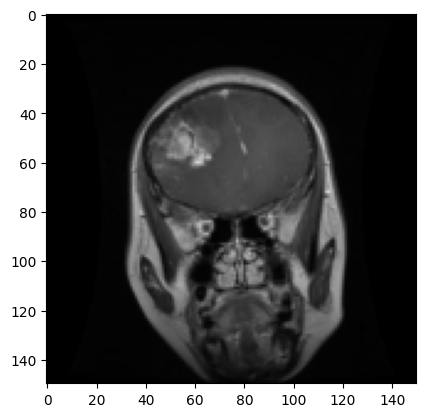

In [4]:
import matplotlib.pyplot as plt

def display_img(img, label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1, 2, 0))

#display the first image in the dataset
display_img(*dataset[0])

In [5]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128

print(f"Length of Train Data : {len(dataset)}")
print(f"Length of test Data : {len(test_dataset)}")


#load the train and test into batches.
train_dl = DataLoader(dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 5712
Length of test Data : 1311


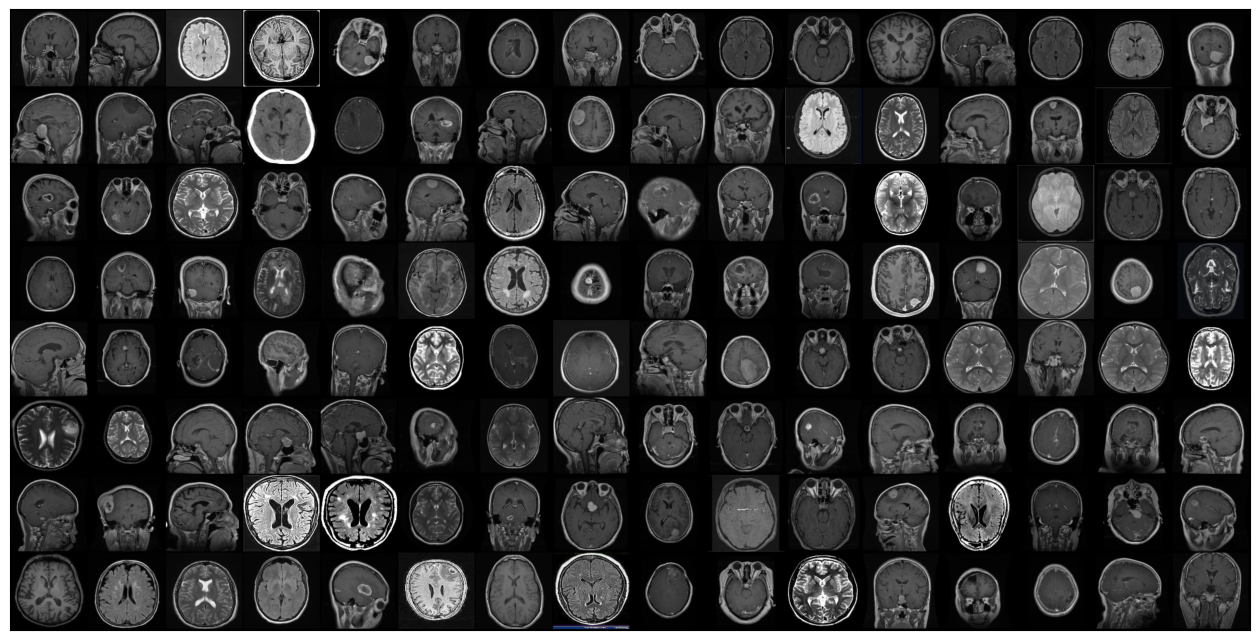

In [6]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.test_step(batch) for batch in test_loader]
    return model.test_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, test_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def test_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'test_loss': loss.detach(), 'test_acc': acc}
        
    def test_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(
            epoch, result['train_loss'], result['test_loss'], result['test_acc']))

In [ ]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,4)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
from torchsummary import summary
summary(NaturalSceneClassification(), input_size=(3, 150, 150))

In [12]:
import pickle

# Define the number of splits
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
num_epochs = 30
lr = 0.001
opt_func = torch.optim.Adam

# Placeholder for cross-validation results
cv_results = []
models = []

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1}/{k}")
    
    # Create train and validation subsets
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)
    
    # Create DataLoaders for train and validation subsets
    train_loader = DataLoader(train_subset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size, num_workers=4, pin_memory=True)
    
    # Initialize the model
    model = NaturalSceneClassification()
    
    # Train the model
    history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)
    
    # Evaluate the model on the validation set
    result = evaluate(model, val_loader)
    cv_results.append(result)
    models.append(model)
    print(f"Validation Loss: {result['test_loss']}, Validation Accuracy: {result['test_acc']}")
    
    # Save the model for the current fold
    with open(f'model_fold_{fold+1}.pkl', 'wb') as f:
        pickle.dump(model, f)

# Save the cross-validation results
with open('cv_results.pkl', 'wb') as f:
    pickle.dump(cv_results, f)

# Calculate average results
avg_loss = sum([x['test_loss'] for x in cv_results]) / k
avg_acc = sum([x['test_acc'] for x in cv_results]) / k

print(f"Average Validation Loss: {avg_loss}")
print(f"Average Validation Accuracy: {avg_acc}")

Fold 1/5
Epoch [0], train_loss: 1.5210, test_loss: 1.3942, test_acc: 0.2526
Epoch [1], train_loss: 1.1190, test_loss: 0.7716, test_acc: 0.7351
Epoch [2], train_loss: 0.6516, test_loss: 0.5558, test_acc: 0.7660
Epoch [3], train_loss: 0.4766, test_loss: 0.4112, test_acc: 0.8412
Epoch [4], train_loss: 0.3874, test_loss: 0.3881, test_acc: 0.8545
Epoch [5], train_loss: 0.3062, test_loss: 0.2854, test_acc: 0.8864
Epoch [6], train_loss: 0.2614, test_loss: 0.3012, test_acc: 0.8872
Epoch [7], train_loss: 0.2007, test_loss: 0.2629, test_acc: 0.9087
Epoch [8], train_loss: 0.1722, test_loss: 0.2315, test_acc: 0.9180
Epoch [9], train_loss: 0.1184, test_loss: 0.2414, test_acc: 0.9217
Epoch [10], train_loss: 0.1301, test_loss: 0.2965, test_acc: 0.9085
Epoch [11], train_loss: 0.1033, test_loss: 0.3217, test_acc: 0.9155
Epoch [12], train_loss: 0.0614, test_loss: 0.2542, test_acc: 0.9364
Epoch [13], train_loss: 0.0590, test_loss: 0.3480, test_acc: 0.9069
Epoch [14], train_loss: 0.0434, test_loss: 0.2885

In [16]:
import pickle

# Save the models list to a file
with open('models.pkl', 'wb') as f:
    pickle.dump(models, f)

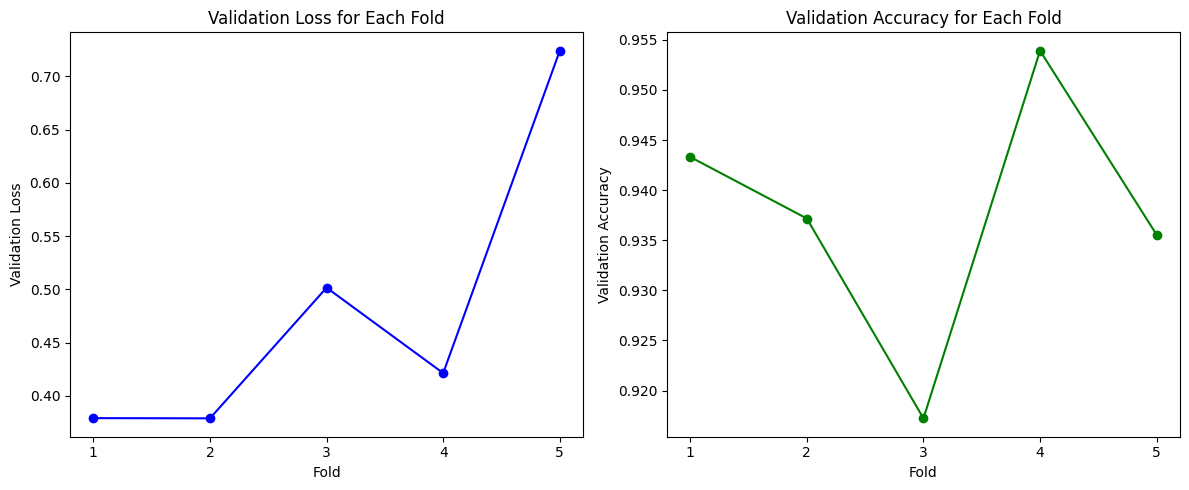

In [13]:
import matplotlib.pyplot as plt

# Extract validation losses and accuracies for each fold
val_losses = [result['test_loss'] for result in cv_results]
val_accuracies = [result['test_acc'] for result in cv_results]

# Plot validation loss for each fold
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, k + 1), val_losses, marker='o', linestyle='-', color='b')
plt.title('Validation Loss for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Validation Loss')
plt.xticks(range(1, k + 1))

# Plot validation accuracy for each fold
plt.subplot(1, 2, 2)
plt.plot(range(1, k + 1), val_accuracies, marker='o', linestyle='-', color='g')
plt.title('Validation Accuracy for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy')
plt.xticks(range(1, k + 1))

plt.tight_layout()
plt.show()

## Majority Voting

In [14]:
import numpy as np

# Placeholder for test predictions
test_predictions = []

# Iterate over the models and make predictions on the test dataset
for i, model in enumerate(models):
    print(f"Predicting with model {i+1}/{len(models)}")
    model.eval()  # Set the model to evaluation mode
    fold_predictions = []
    with torch.no_grad():
        for images, _ in test_dl:
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            fold_predictions.extend(preds.cpu().numpy())
    test_predictions.append(fold_predictions)

# Convert the list of predictions to a numpy array for easier manipulation
test_predictions = np.array(test_predictions)

# Aggregate predictions (e.g., majority voting)
final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=test_predictions)

print("Final predictions on test data:", final_predictions)

Predicting with model 1/5
Predicting with model 2/5
Predicting with model 3/5
Predicting with model 4/5
Predicting with model 5/5
Final predictions on test data: [0 0 0 ... 3 3 3]


Test Accuracy: 0.9748283752860412


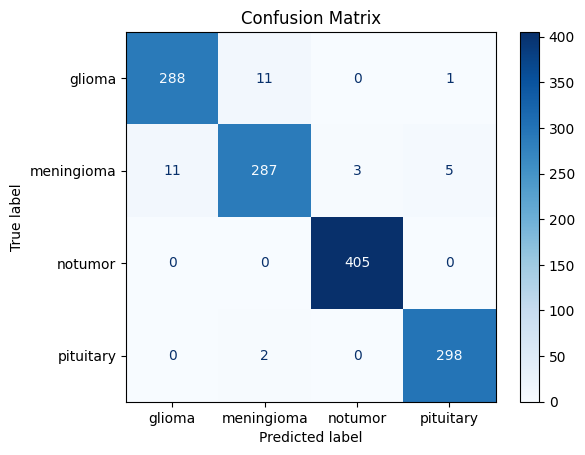

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Extract the true labels from the test dataset
true_labels = [label for _, label in test_dataset]

# Calculate the accuracy
accuracy = accuracy_score(true_labels, final_predictions)
print(f"Test Accuracy: {accuracy}")

# Compute the confusion matrix
cm = confusion_matrix(true_labels, final_predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Average Voting

In [17]:
import numpy as np
import torch

# Placeholder for test predictions
test_predictions = []

# Iterate over the models and make predictions on the test dataset
for i, model in enumerate(models):
    print(f"Predicting with model {i+1}/{len(models)}")
    model.eval()  # Set the model to evaluation mode
    fold_predictions = []
    with torch.no_grad():
        for images, _ in test_dl:
            outputs = model(images)
            preds = torch.softmax(outputs, dim=1)  # Get probabilities
            fold_predictions.extend(preds.cpu().numpy())
    test_predictions.append(fold_predictions)

# Convert the list of predictions to a numpy array for easier manipulation
test_predictions = np.array(test_predictions)

# Calculate the average predictions
average_predictions = np.mean(test_predictions, axis=0)

# Convert average predictions to final predicted labels
final_predictions = np.argmax(average_predictions, axis=1)

print("Final predictions on test data:", final_predictions)

Predicting with model 1/5
Predicting with model 2/5
Predicting with model 3/5
Predicting with model 4/5
Predicting with model 5/5
Final predictions on test data: [0 0 0 ... 3 3 3]


Test Accuracy: 0.9755911517925248


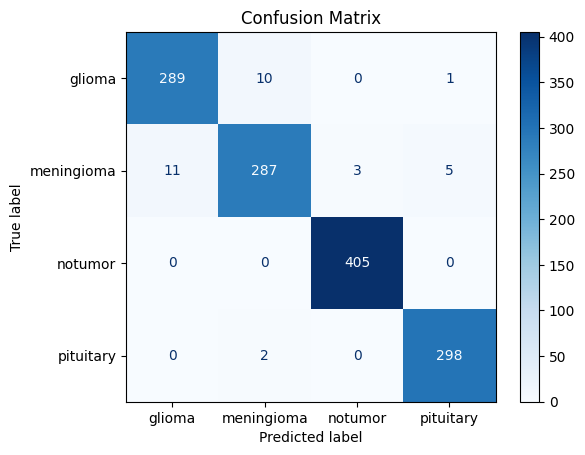

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Extract the true labels from the test dataset
true_labels = [label for _, label in test_dataset]

# Calculate the accuracy
accuracy = accuracy_score(true_labels, final_predictions)
print(f"Test Accuracy: {accuracy}")

# Compute the confusion matrix
cm = confusion_matrix(true_labels, final_predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()